## CLOSING TRIANGLES IN A LITERARY SOCIAL NETWORK


Your task will be to analyze the temporal evolution of a social network of literary characters by exploring how open triangles become closed, emulating the triadic closure mechanism seen in class.

– For inspiration (and implementation details!), first read the following two papers related to temporal networks of literary texts:

1) Prado, Sandra D., et al. “Temporal network analysis of literary texts.” Advances in Complex Systems
19.03 (2016): 1650005. (LINK) (ARXIV).

2) Min, Semi, and Juyong Park. “Modeling narrative structure and dynamics with networks, senti-
ment analysis, and topic modeling.” PLoS ONE 14.12 (2019): e0226025. (LINK) (ARXIV).

– Just like in assignment 4, choose a digitized book that you really like. You can find thousands of freely available books on the Project Gutenberg (LINK). Another option is to use the corpora from Python’s Natural Language Toolkit (LINK; for details on accessing the text corpora see: LINK).

– Construct a growing social network of characters in the book. First, determine the N characters that appear by name at least once in the book, and build an empty network with N nodes (this is your network at time t = 0). Pick a text ‘time unit’ (it could be consecutive word windows of i.e. T = 500 words, or pages, in case you have that information in your digitized book). Define a link between characters i and j if both characters are mentioned in the same time unit. Then, slide the time unit throughout the whole text (indicating times t = 1, 2, . . .) and draw the links that correspond to each time unit, keeping all links that appeared before. The result should be the time series of a growing social network that gets more links as characters ‘meet’ in the same time unit.

– Stop and look at your social network. What do you see? What does it mean? How could you explain its structure in terms of the story of the book?

– Explore triadic closure in your social network. Look for open triangles (triads of nodes with only 2links between them) that become closed triangles (i.e. get an extra link) some time later. How many open and closed triangles do you have? What is the typical time needed for an open triangle to get closed?

– Write a short report summarizing your results. Describe your dataset, the pre-processing (if any), the algorithm you used to create the network, and your results (include plots for the growing social network and the analysis of open/closed triangles). Append the Python scripts used, but describe what they do in the report.

– LLM update: You may use LLMs to write snippets of code for data analysis, or to rewrite your results. If you do so, report all prompts and answers in your interaction with the LLM. Answer the question: What part of the process did the LLM help you improve, if any?

In [1]:
import numpy as np
import pandas as pd


In [3]:
import nltk
#nltk.download('gutenberg')
from nltk.corpus import gutenberg
#nltk.download()
#nltk.download('punkt')
#nltk.download('stopwords')


gutenberg.fileids() # these are the book corpora included in nltk

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [15]:
words = gutenberg.words('shakespeare-caesar.txt') #I chose this this time, maybe more modern means less filtered words
#words = gutenberg.words('carroll-alice.txt') 
words[0:15]

['[',
 'The',
 'Tragedie',
 'of',
 'Julius',
 'Caesar',
 'by',
 'William',
 'Shakespeare',
 '1599',
 ']',
 'Actus',
 'Primus',
 '.',
 'Scoena']

In [16]:
len(words)

25833

In [90]:
#Macros
block_size = 1000

Minus 1: Choosing a sentiment dictionary

0. Preprocessing

only used token B in the end

In [64]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def preprocess_text(text,ltype):
    text2 = text.copy()
    text3 = [word.lower() for word in text2]

    if (ltype=='B') | (ltype=='C'):
        for word in text:
         #There is Porter Stemmer too, but I'd just skip it for now
            if (word.isalpha() == False):
                text3.remove(word)
            if (ltype=='C'):
                if word in stopwords.words('english'):
                    text3.remove(word)
        
    
    tokens = word_tokenize(' '.join(text3))
   
    return tokens

tokens_A = preprocess_text(list(words), 'A')
tokens_B = preprocess_text(list(words), 'B')
tokens_C = preprocess_text(list(words), 'C')
print(len(tokens_A), len(tokens_B), len(tokens_C))

25840 20809 13295


In [91]:
blocks = []


for i in range(0, len(tokens_B), block_size):
    block = tokens_B[i:i+block_size]
    blocks.append(block)

1) Determine all characters that appear at least once in the book

I did this, manually, looked at here: https://www.gutenberg.org/cache/epub/1522/pg1522-images.html and gathered the names

In [66]:
characters=[
    "caesar",
    "octavius",
    "lepidus",
    "antony", #he also sometimes appears as Antonius, but only 4 times
    "cicero",
    "lepidus",
    "publius",
    "popilius",
    "brutus",
    "cassius",
    "casca",
    "trebonius",
    "ligarius",
    "decius",
    "metellus",
    "cinna",
    "flavius",
    "marullus",
    "artemidorus",
    "soothsayer",
    "cinna",
    "lucilius",
    "titinius",
    "messala",
    "cato",
    "volumnius",
    "varro", "clitus", "claudius", "strato", "lucius", "dardanius",
    "pindarus",
    "calphurnia",
    "portia",
]

N= len(characters)

In [219]:
import igraph as ig

# Create a graph with no edges and N vertices, with the names of the characters
g = ig.Graph(N)
g.vs['name'] = characters
g.vs["label"] = g.vs["name"]
layout = g.layout(layout='reingold_tilford_circular')
#ig.plot(g, layout=layout)


In [220]:
charblocks = []
for i in range(len(blocks)):
    char_in_block = []
    for word in blocks[i]:
        if word in characters:
            char_in_block.append(word)
    char_in_block = list(set(char_in_block))
    charblocks.append(char_in_block)
charblocks

[['portia',
  'brutus',
  'caesar',
  'decius',
  'cicero',
  'calphurnia',
  'soothsayer',
  'cassius',
  'antony'],
 ['brutus', 'cassius', 'caesar', 'titinius'],
 ['brutus', 'caesar', 'cicero', 'calphurnia', 'cassius', 'antony'],
 ['brutus', 'cassius', 'caesar', 'cicero'],
 ['trebonius',
  'brutus',
  'cinna',
  'caesar',
  'metellus',
  'decius',
  'cassius',
  'lucius'],
 ['trebonius',
  'brutus',
  'cinna',
  'caesar',
  'metellus',
  'decius',
  'cicero',
  'cassius',
  'lucius'],
 ['portia',
  'brutus',
  'caesar',
  'metellus',
  'decius',
  'cassius',
  'antony',
  'lucius',
  'ligarius'],
 ['portia',
  'brutus',
  'cato',
  'metellus',
  'caesar',
  'calphurnia',
  'lucius',
  'ligarius'],
 ['trebonius',
  'brutus',
  'portia',
  'caesar',
  'metellus',
  'decius',
  'publius',
  'calphurnia',
  'artemidorus',
  'cassius',
  'ligarius',
  'lucius',
  'antony'],
 ['trebonius',
  'brutus',
  'cinna',
  'caesar',
  'metellus',
  'decius',
  'publius',
  'soothsayer',
  'cassius'

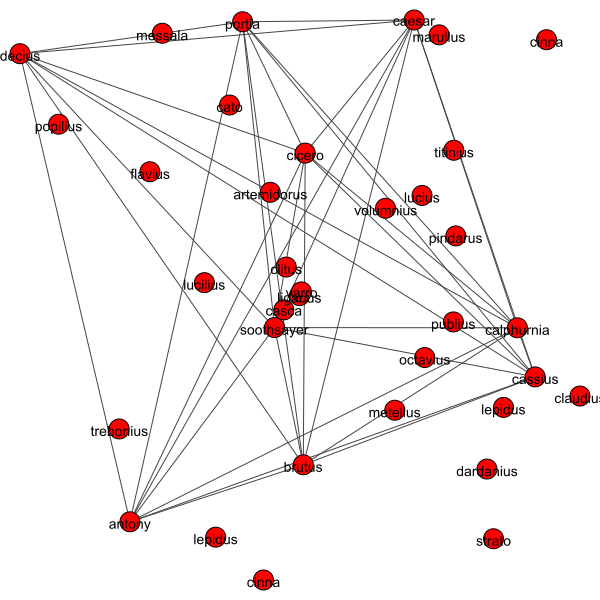

In [223]:
vertices = g.vs.select(name_in = charblocks[0])
for v in vertices:
    for w in vertices:
        if (v != w) & (g.get_eid(v, w, directed=False, error=False) == -1):
            g.add_edge(v, w)
ig.plot(g, layout="lgl")

Cairo plots awfully with overlaps and no optimilazation, trying all layouts and even the best "large" is bad, so... switching to networkx

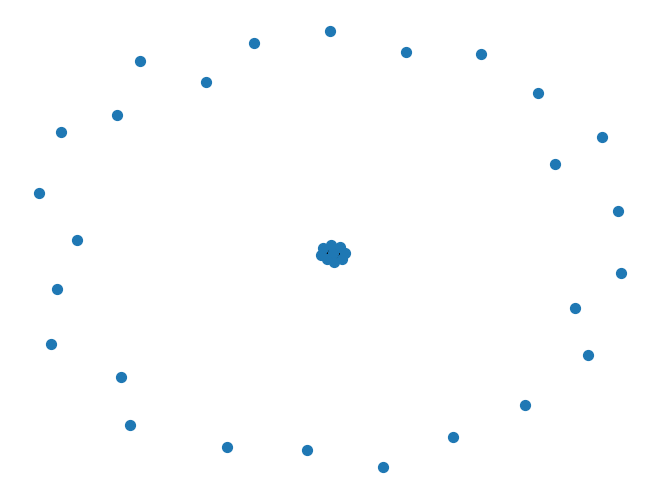

In [224]:
import networkx as nx

G = g.to_networkx()

nx.draw(G, node_size=50)

In [205]:
nx.get_node_attributes(G,'name')

{0: 'caesar',
 1: 'octavius',
 2: 'lepidus',
 3: 'antony',
 4: 'cicero',
 5: 'lepidus',
 6: 'publius',
 7: 'popilius',
 8: 'brutus',
 9: 'cassius',
 10: 'casca',
 11: 'trebonius',
 12: 'ligarius',
 13: 'decius',
 14: 'metellus',
 15: 'cinna',
 16: 'flavius',
 17: 'marullus',
 18: 'artemidorus',
 19: 'soothsayer',
 20: 'cinna',
 21: 'lucilius',
 22: 'titinius',
 23: 'messala',
 24: 'cato',
 25: 'volumnius',
 26: 'varro',
 27: 'clitus',
 28: 'claudius',
 29: 'strato',
 30: 'lucius',
 31: 'dardanius',
 32: 'pindarus',
 33: 'calphurnia',
 34: 'portia'}

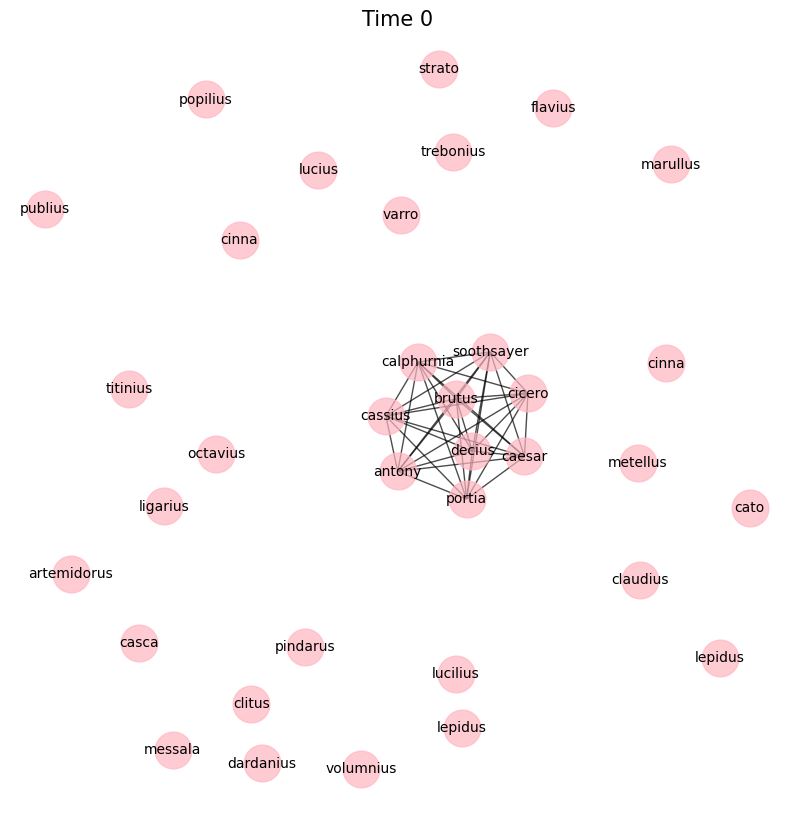

In [225]:
import matplotlib.pyplot as plt

def viz(g,layout, title):
    plt.figure(figsize=(10, 10))
    nx.draw_networkx_nodes(g, layout, node_color='lightpink', node_size=700, linewidths=None, alpha=0.7)
    nx.draw_networkx_edges(g, layout, alpha=0.7, edge_color='black')
    nx.draw_networkx_labels(g, layout, font_size=10, font_family='sans-serif', labels=nx.get_node_attributes(g,'name'))
    plt.title(title, size=15)
    plt.axis('off')  # Turn off the axis
    plt.show()

consistent_layout = nx.spring_layout(G, k=0.3, iterations=10)
viz(G, consistent_layout, "Time 0")

Yeah, this is cooler.

In [226]:
def viz_6(gs,layout, titles):
    plt.figure(figsize=(20, 20))
    for i in range(len(gs)):
        plt.subplot(3, 2, i+1)
        nx.draw_networkx_nodes(gs[i], layout, node_color='lightpink', node_size=300, linewidths=None, alpha=0.7)
        nx.draw_networkx_edges(gs[i], layout, alpha=0.7, edge_color='black')
        nx.draw_networkx_labels(gs[i], layout, font_size=10, font_family='sans-serif', labels=nx.get_node_attributes(gs[i],'name'))
        plt.title(titles[i], size=15)
        plt.axis('off')  # Turn off the axis
        #Set ax size to equal
        ax = plt.gca()
        ax.set_aspect('equal')
        
    plt.show()

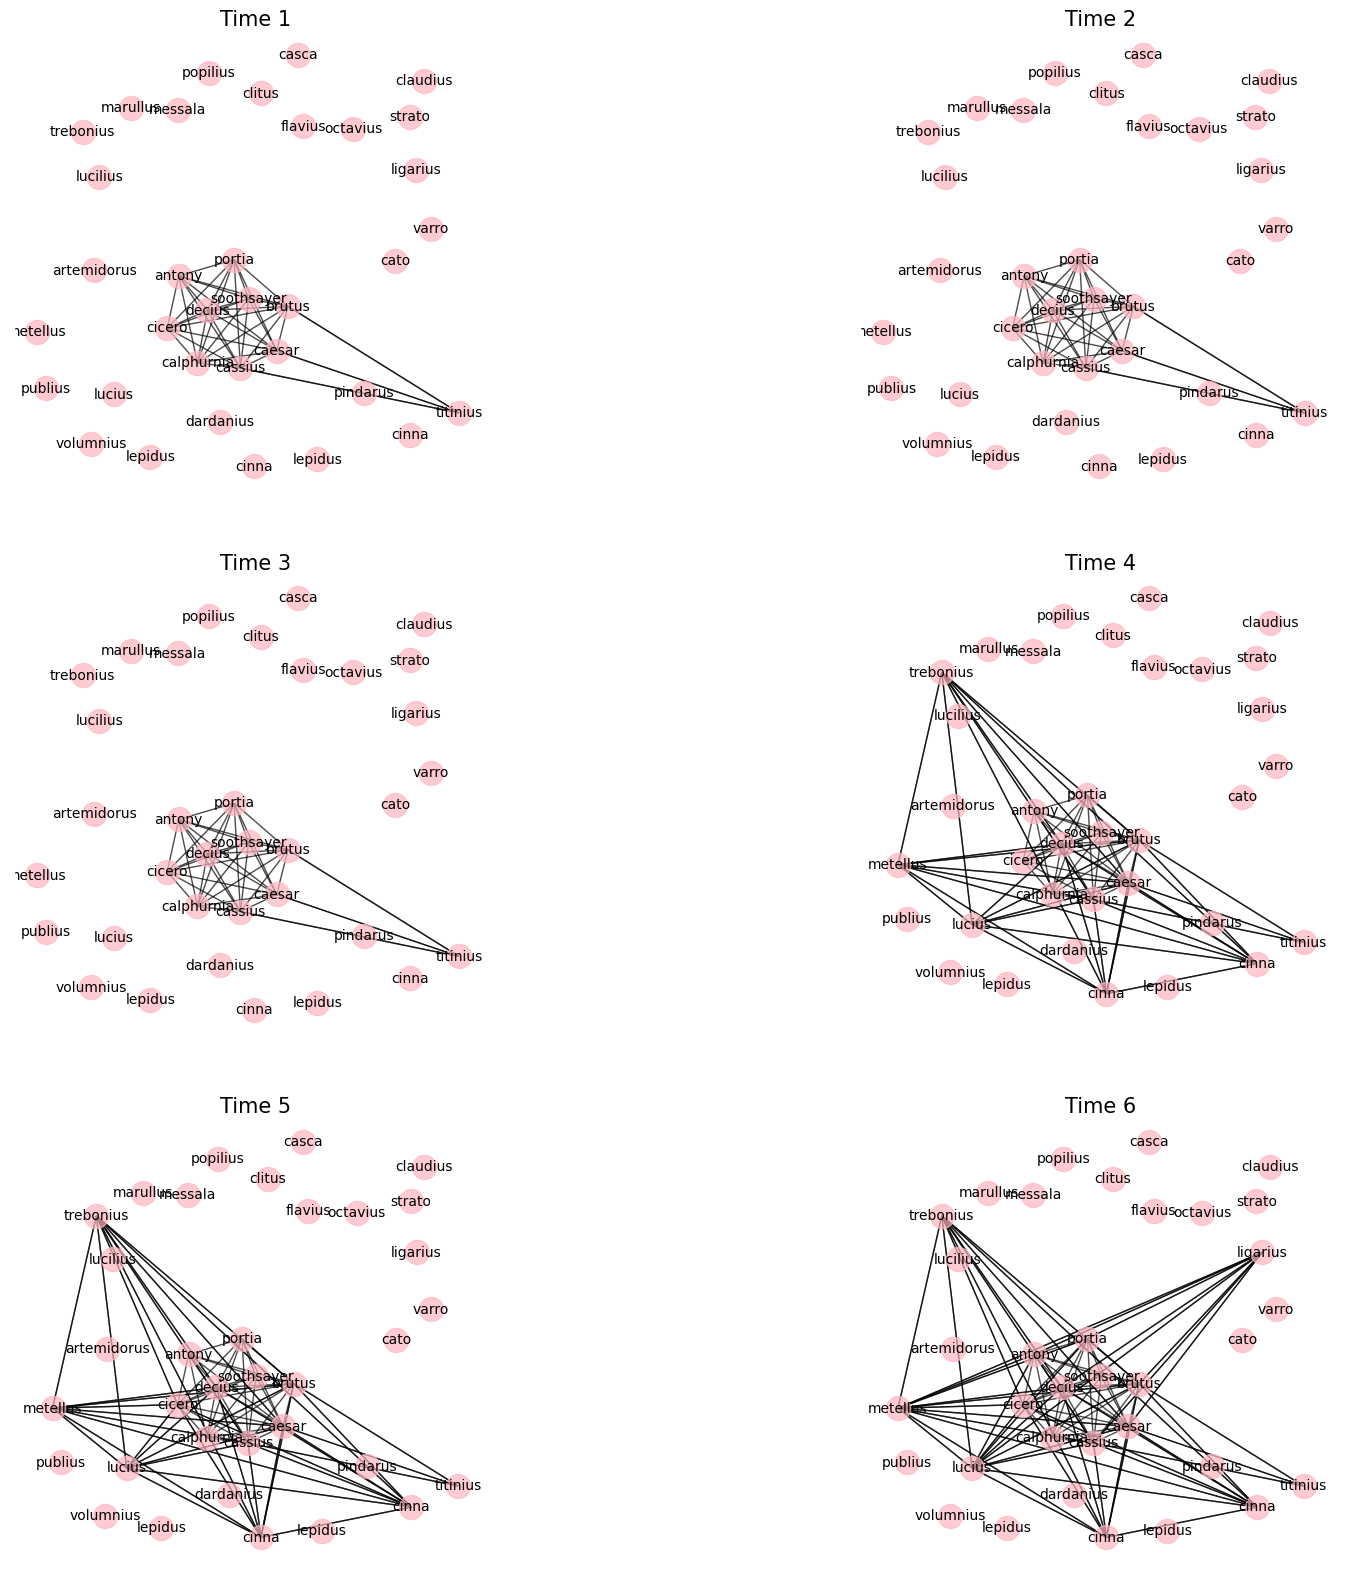

In [227]:
graphs=[]
graphs.append(G)
graphs6 = []
for i in range(1, 7):
    g_full = g.copy()
    vertices = g.vs.select(name_in = charblocks[i])
    for v in vertices:
        for w in vertices:
            if (v != w) & (g.get_eid(v, w, directed=False, error=False) == -1):
                g_full.add_edge(v, w)
    g = g_full.copy()
    Gn = g.to_networkx()
    graphs6.append(Gn); graphs.append(Gn)


consistent_layout = nx.spring_layout(G, k=0.4, iterations=10)
titles = ["Time 1","Time 2","Time 3","Time 4","Time 5","Time 6"]
viz_6(graphs6, consistent_layout, titles=titles)


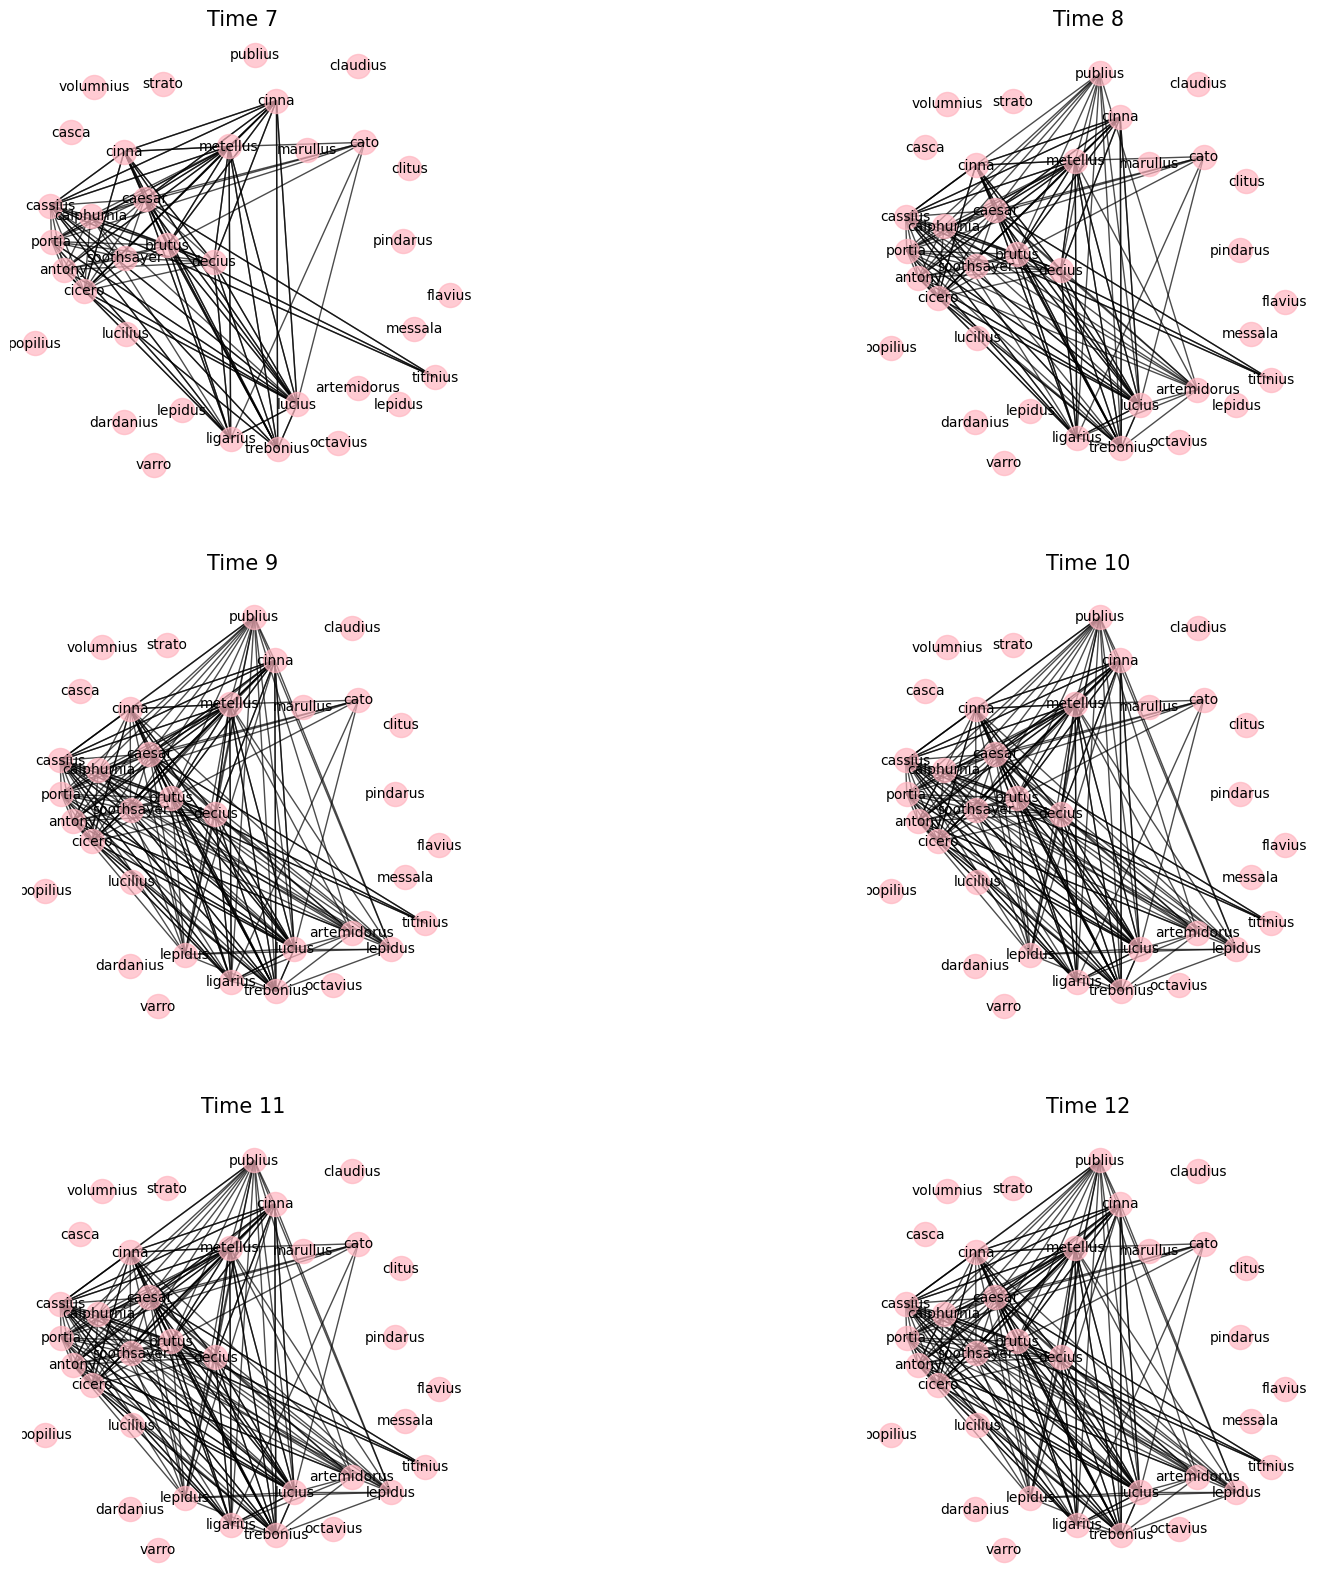

In [228]:
graphs12 = []
for i in range(7, 13):
    vertices = g.vs.select(name_in = charblocks[i])
    for v in vertices:
        for w in vertices:
            if (v != w) & (g.get_eid(v, w, directed=False, error=False) == -1):
                g.add_edge(v, w)
    ig.plot(g, layout="lgl")
    Gn = g.to_networkx()
    graphs12.append(Gn); graphs.append(Gn)

consistent_layout = nx.spring_layout(G, k=0.4, iterations=10)
titles = ["Time 7","Time 8","Time 9","Time 10","Time 11","Time 12"]
viz_6(graphs12, consistent_layout, titles=titles)


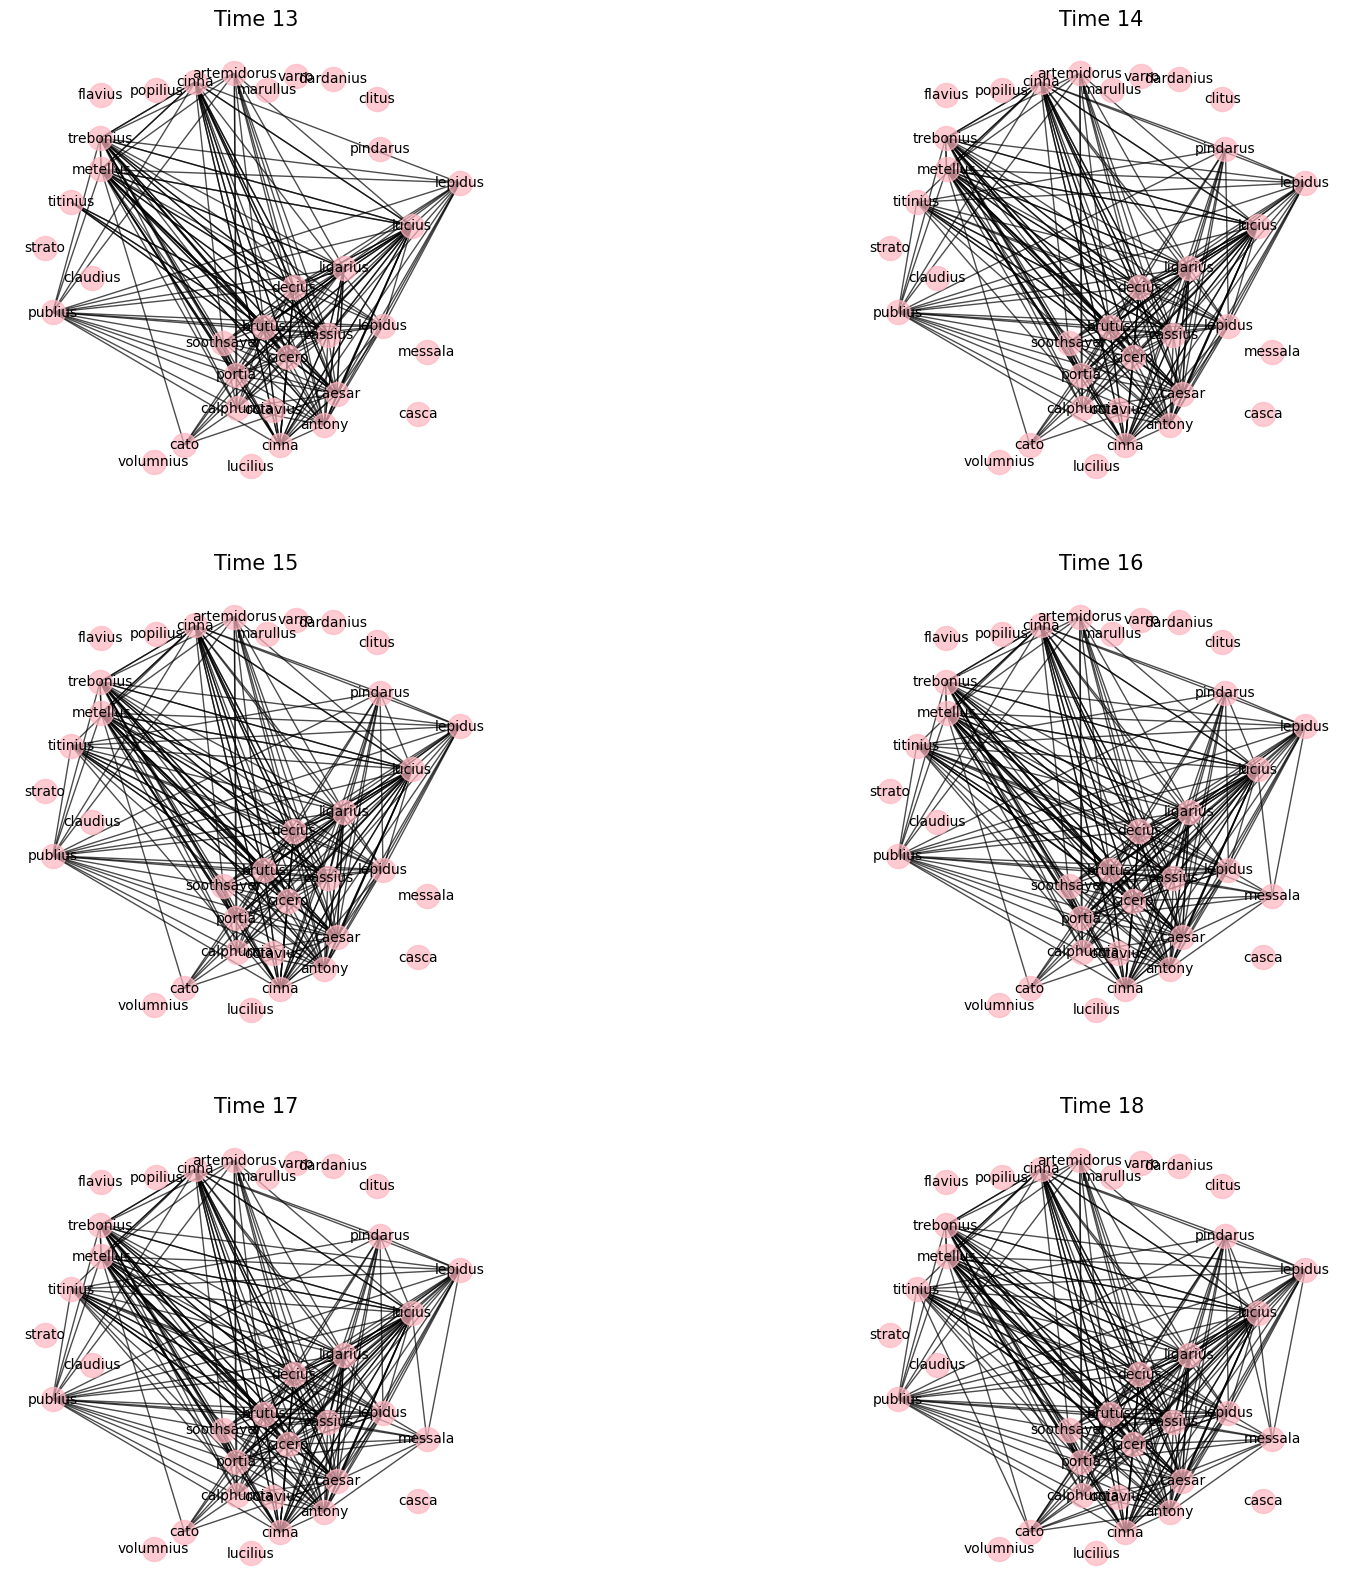

In [230]:
graphs18 = []
for i in range(13, 19):
    vertices = g.vs.select(name_in = charblocks[i])
    for v in vertices:
        for w in vertices:
            if (v != w) & (g.get_eid(v, w, directed=False, error=False) == -1):
                g.add_edge(v, w)
    ig.plot(g, layout="lgl")
    Gn = g.to_networkx()
    graphs18.append(Gn); graphs.append(Gn)

consistent_layout = nx.spring_layout(G, k=0.4, iterations=10)
titles = ["Time 13","Time 14","Time 15","Time 16","Time 17","Time 18"]
viz_6(graphs18, consistent_layout, titles=titles)


In [345]:
charblocks[16]

['portia',
 'brutus',
 'caesar',
 'cicero',
 'messala',
 'cassius',
 'lepidus',
 'lucius',
 'titinius',
 'antony']

In [340]:
charblocks[19]

['brutus',
 'cato',
 'volumnius',
 'caesar',
 'strato',
 'messala',
 'cassius',
 'pindarus',
 'titinius',
 'antony']

In [343]:
charblocks[20]

['clitus',
 'brutus',
 'volumnius',
 'caesar',
 'dardanius',
 'strato',
 'messala',
 'antony']

In [ ]:
graphs24 = []
for i in range(19, 21):
    vertices = g.vs.select(name_in = charblocks[i])
    for v in vertices:
        for w in vertices:
            if (v != w) & (g.get_eid(v, w, directed=False, error=False) == -1):
                g.add_edge(v, w)
    ig.plot(g, layout="lgl")
    Gn = g.to_networkx()
    graphs24.append(Gn); graphs.append(Gn)


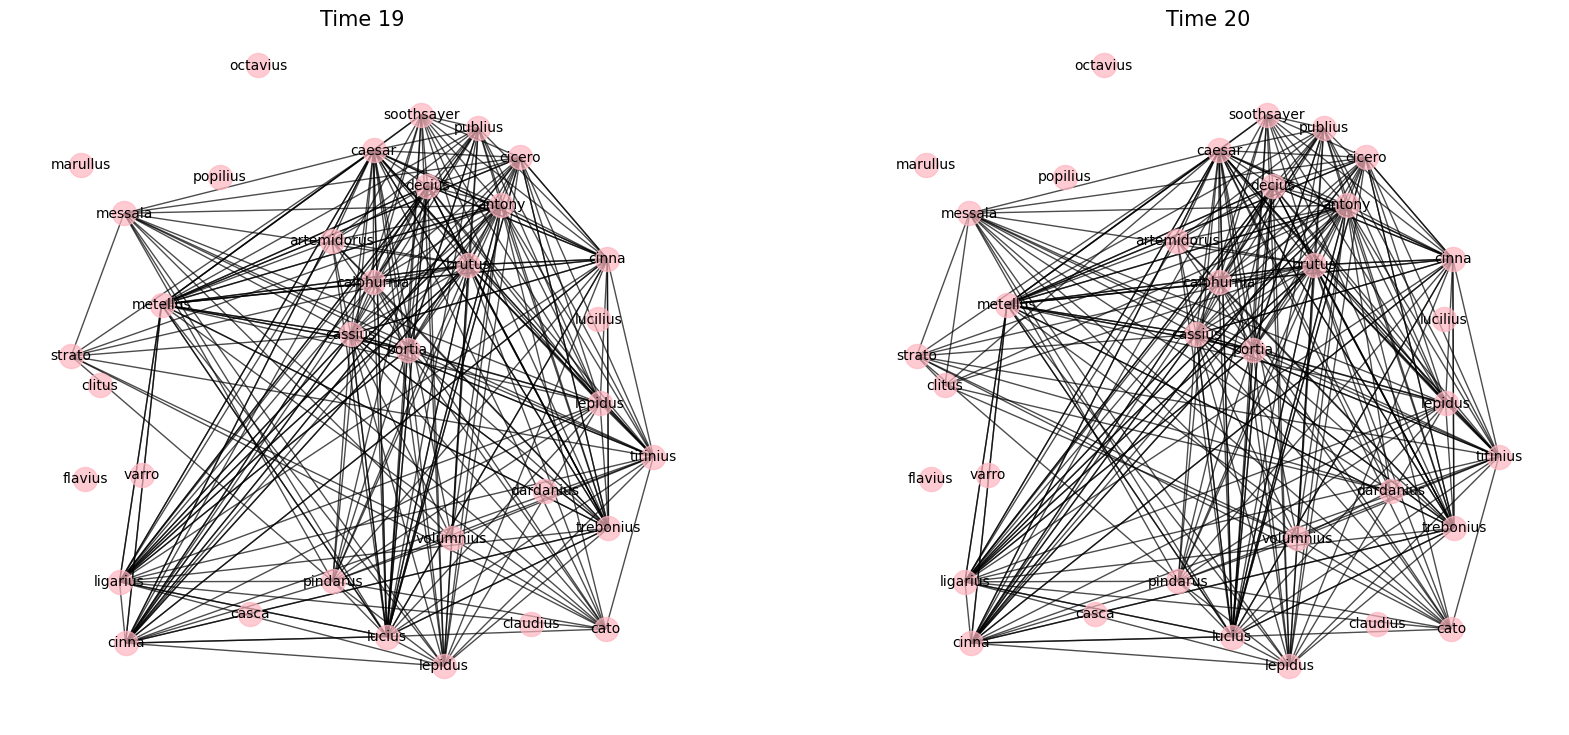

In [236]:
def viz_2(gs,layout,titles):
    plt.figure(figsize=(20, 10))
    for i in range(2):
        plt.subplot(1, 2, i+1)
        nx.draw_networkx_nodes(gs[i], layout, node_color='lightpink', node_size=300, linewidths=None, alpha=0.7)
        nx.draw_networkx_edges(gs[i], layout, alpha=0.7, edge_color='black')
        nx.draw_networkx_labels(gs[i], layout, font_size=10, font_family='sans-serif', labels=nx.get_node_attributes(gs[i],'name'))
        plt.title(titles[i], size=15)
        plt.axis('off')  # Turn off the axis
        #Set ax size to equal
        ax = plt.gca()
        ax.set_aspect('equal')
        
    plt.show()

consistent_layout = nx.spring_layout(G, k=0.4, iterations=10)
titles = ["Time 19","Time 20"]
viz_2(graphs24, consistent_layout, titles=titles)

Interestingly, Octavius was not in the processed tokens (and so were not flavius, popilius, and so on)

In [249]:
"octavius" in tokens_B

False

In [373]:
clean=graphs24[1].copy()

In [375]:
processed =[]
remove = []
for u, v, in clean.edges():
    if (u,v) not in processed:
        #print(u,v)
        processed.append((u,v))
    else:
        remove.append((u,v))

clean.remove_edges_from(remove)
clean.remove_nodes_from(list(nx.isolates(clean)))

In [376]:
for i in range(35):
    try:
        print("Name:",nx.get_node_attributes(clean,"name")[i] ,clean.degree[i])
    except:
        continue

Name: caesar 26
Name: lepidus 19
Name: antony 26
Name: cicero 17
Name: lepidus 19
Name: publius 19
Name: brutus 26
Name: cassius 24
Name: trebonius 18
Name: ligarius 19
Name: decius 20
Name: metellus 19
Name: cinna 17
Name: artemidorus 12
Name: soothsayer 16
Name: cinna 17
Name: titinius 19
Name: messala 16
Name: cato 14
Name: volumnius 11
Name: clitus 7
Name: strato 11
Name: lucius 22
Name: dardanius 7
Name: pindarus 17
Name: calphurnia 15
Name: portia 19


In [383]:
for g in graphs:
    print(g)

Graph with 35 nodes and 36 edges
MultiGraph with 35 nodes and 42 edges
MultiGraph with 35 nodes and 42 edges
MultiGraph with 35 nodes and 42 edges
MultiGraph with 35 nodes and 102 edges
MultiGraph with 35 nodes and 112 edges
MultiGraph with 35 nodes and 136 edges
MultiGraph with 35 nodes and 146 edges
MultiGraph with 35 nodes and 173 edges
MultiGraph with 35 nodes and 208 edges
MultiGraph with 35 nodes and 208 edges
MultiGraph with 35 nodes and 208 edges
MultiGraph with 35 nodes and 208 edges
MultiGraph with 35 nodes and 208 edges
MultiGraph with 35 nodes and 232 edges
MultiGraph with 35 nodes and 234 edges
MultiGraph with 35 nodes and 250 edges
MultiGraph with 35 nodes and 250 edges
MultiGraph with 35 nodes and 256 edges
MultiGraph with 35 nodes and 273 edges
MultiGraph with 35 nodes and 286 edges


In [389]:
density = []
for g in graphs: #Density
    subgraph = (g).copy()
    subgraph.remove_nodes_from(list(nx.isolates(subgraph)))
    subgraph.remove_edges_from(list(nx.selfloop_edges(subgraph)))
    processed =[]
    remove = []
    for u, v, in subgraph.edges():
        if (u,v) not in processed:
            #print(u,v)
            processed.append((u,v))
        else:
            remove.append((u,v))

    subgraph.remove_edges_from(remove)
    print(nx.density(subgraph))
    density.append(nx.density(subgraph))

1.0
0.8666666666666667
0.8666666666666667
0.8666666666666667
0.6571428571428571
0.7047619047619048
0.7166666666666667
0.7058823529411765
0.7192982456140351
0.7523809523809524
0.7523809523809524
0.7523809523809524
0.7523809523809524
0.7523809523809524
0.7878787878787878
0.7965367965367965
0.7905138339920948
0.7905138339920948
0.8142292490118577
0.7433333333333333
0.6723646723646723


(0.0, 1.0)

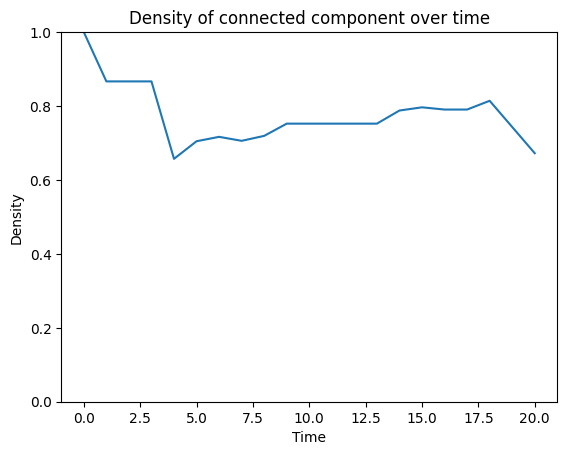

In [394]:
sns.lineplot(density)
plt.title("Density of connected component over time")
plt.xlabel("Time")
plt.ylabel("Density")
plt.ylim(0,1)


In [395]:
for g in graphs:
    subgraph = (g).copy()
    processed =[]
    remove = []
    for u, v, in subgraph.edges():
        if (u,v) not in processed:
            #print(u,v)
            processed.append((u,v))
        else:
            remove.append((u,v))

    subgraph.remove_edges_from(remove)
    print(nx.density(subgraph))
    density.append(nx.density(subgraph))
density

0.06050420168067227
0.06554621848739496
0.06554621848739496
0.06554621848739496
0.11596638655462185
0.12436974789915967
0.14453781512605043
0.16134453781512606
0.20672268907563024
0.26554621848739496
0.26554621848739496
0.26554621848739496
0.26554621848739496
0.26554621848739496
0.3058823529411765
0.3092436974789916
0.33613445378151263
0.33613445378151263
0.346218487394958
0.37478991596638656
0.39663865546218485


[1.0,
 0.8666666666666667,
 0.8666666666666667,
 0.8666666666666667,
 0.6571428571428571,
 0.7047619047619048,
 0.7166666666666667,
 0.7058823529411765,
 0.7192982456140351,
 0.7523809523809524,
 0.7523809523809524,
 0.7523809523809524,
 0.7523809523809524,
 0.7523809523809524,
 0.7878787878787878,
 0.7965367965367965,
 0.7905138339920948,
 0.7905138339920948,
 0.8142292490118577,
 0.7433333333333333,
 0.6723646723646723,
 0.06050420168067227,
 0.06554621848739496,
 0.06554621848739496,
 0.06554621848739496,
 0.11596638655462185,
 0.12436974789915967,
 0.14453781512605043,
 0.16134453781512606,
 0.20672268907563024,
 0.26554621848739496,
 0.26554621848739496,
 0.26554621848739496,
 0.26554621848739496,
 0.26554621848739496,
 0.3058823529411765,
 0.3092436974789916,
 0.33613445378151263,
 0.33613445378151263,
 0.346218487394958,
 0.37478991596638656,
 0.39663865546218485]

(0.0, 1.0)

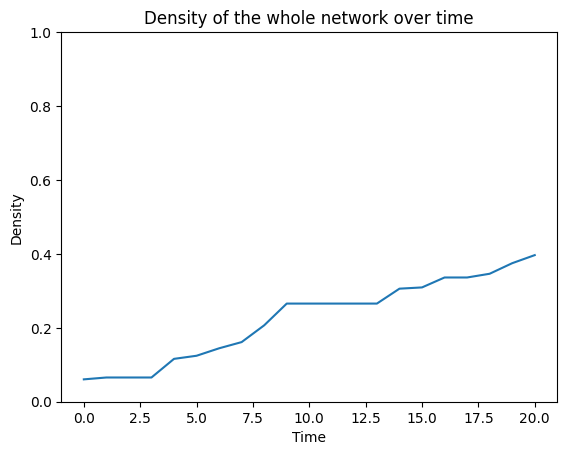

In [400]:
comp_dest = density[21:]
sns.lineplot(comp_dest)
plt.title("Density of the whole network over time")
plt.xlabel("Time")
plt.ylabel("Density")
plt.ylim(0,1)


In [316]:
open_triangles = [] # A,B,C triples where A and B are connected, and B and C are connected, but A and C are not
close_interval = []

for m in range(len(graphs)):
    g = graphs[m]
    # Check which open triangles got closed
    it_open_triangles = open_triangles.copy()
    for i in range(len(it_open_triangles)):
        if (g.has_edge(it_open_triangles[i][0][0], it_open_triangles[i][0][2]) )& (g.has_edge(it_open_triangles[i][0][1], it_open_triangles[i][0][2])) & (g.has_edge(it_open_triangles[i][0][0], it_open_triangles[i][0][1])):
            close_interval.append((it_open_triangles[i][2], m, "diff", m-int(it_open_triangles[i][2])) )
            open_triangles.remove(it_open_triangles[i])


    for i in range(len(g.nodes)):
        for j in range(i+1, len(g.nodes)):
            for k in range(j+1, len(g.nodes)):
                if g.has_edge(list(g.nodes)[i], list(g.nodes)[j]) and g.has_edge(list(g.nodes)[j], list(g.nodes)[k]) and not g.has_edge(list(g.nodes)[i], list(g.nodes)[k]):
                    triangle = tuple(sorted([list(g.nodes)[i], list(g.nodes)[j], list(g.nodes)[k]]))
                    if triangle not in [t[0] for t in open_triangles]:
                        open_triangles.append((triangle, "opened:", m))
open_triangles

[((4, 8, 12), 'opened:', 6),
 ((4, 9, 12), 'opened:', 6),
 ((12, 13, 19), 'opened:', 6),
 ((15, 30, 34), 'opened:', 6),
 ((20, 30, 34), 'opened:', 6),
 ((4, 8, 24), 'opened:', 7),
 ((4, 14, 24), 'opened:', 7),
 ((11, 14, 24), 'opened:', 7),
 ((13, 14, 24), 'opened:', 7),
 ((15, 30, 33), 'opened:', 7),
 ((20, 30, 33), 'opened:', 7),
 ((4, 8, 18), 'opened:', 8),
 ((4, 9, 18), 'opened:', 8),
 ((4, 11, 12), 'opened:', 8),
 ((4, 11, 18), 'opened:', 8),
 ((4, 13, 18), 'opened:', 8),
 ((4, 14, 18), 'opened:', 8),
 ((6, 8, 24), 'opened:', 8),
 ((6, 12, 24), 'opened:', 8),
 ((6, 14, 24), 'opened:', 8),
 ((11, 12, 24), 'opened:', 8),
 ((2, 3, 18), 'opened:', 9),
 ((2, 3, 33), 'opened:', 9),
 ((2, 6, 18), 'opened:', 9),
 ((2, 6, 33), 'opened:', 9),
 ((2, 8, 18), 'opened:', 9),
 ((2, 8, 24), 'opened:', 9),
 ((2, 8, 33), 'opened:', 9),
 ((2, 9, 18), 'opened:', 9),
 ((2, 9, 33), 'opened:', 9),
 ((2, 11, 18), 'opened:', 9),
 ((2, 11, 33), 'opened:', 9),
 ((2, 13, 18), 'opened:', 9),
 ((2, 13, 33), 'o

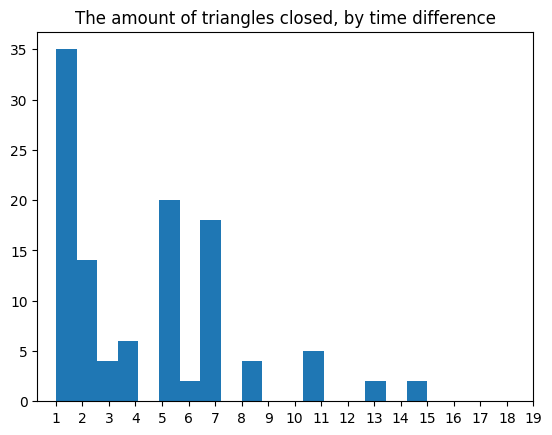

In [377]:
closetimes = [x[3] for x in close_interval]
plt.hist(closetimes, bins=18)
plt.xticks(range(1, 20));
plt.title("The amount of triangles closed, by time difference");

In [318]:
open_triangles

[((4, 8, 12), 'opened:', 6),
 ((4, 9, 12), 'opened:', 6),
 ((12, 13, 19), 'opened:', 6),
 ((15, 30, 34), 'opened:', 6),
 ((20, 30, 34), 'opened:', 6),
 ((4, 8, 24), 'opened:', 7),
 ((4, 14, 24), 'opened:', 7),
 ((11, 14, 24), 'opened:', 7),
 ((13, 14, 24), 'opened:', 7),
 ((15, 30, 33), 'opened:', 7),
 ((20, 30, 33), 'opened:', 7),
 ((4, 8, 18), 'opened:', 8),
 ((4, 9, 18), 'opened:', 8),
 ((4, 11, 12), 'opened:', 8),
 ((4, 11, 18), 'opened:', 8),
 ((4, 13, 18), 'opened:', 8),
 ((4, 14, 18), 'opened:', 8),
 ((6, 8, 24), 'opened:', 8),
 ((6, 12, 24), 'opened:', 8),
 ((6, 14, 24), 'opened:', 8),
 ((11, 12, 24), 'opened:', 8),
 ((2, 3, 18), 'opened:', 9),
 ((2, 3, 33), 'opened:', 9),
 ((2, 6, 18), 'opened:', 9),
 ((2, 6, 33), 'opened:', 9),
 ((2, 8, 18), 'opened:', 9),
 ((2, 8, 24), 'opened:', 9),
 ((2, 8, 33), 'opened:', 9),
 ((2, 9, 18), 'opened:', 9),
 ((2, 9, 33), 'opened:', 9),
 ((2, 11, 18), 'opened:', 9),
 ((2, 11, 33), 'opened:', 9),
 ((2, 13, 18), 'opened:', 9),
 ((2, 13, 33), 'o

In [332]:
len(open_triangles), len(close_interval)

(198, 112)

In [325]:
import seaborn as sns

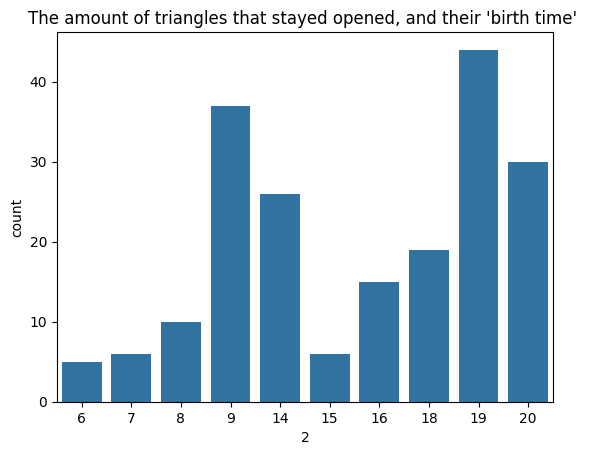

In [380]:
vals = pd.DataFrame(open_triangles)[2].value_counts()

sns.barplot(vals )
plt.title("The amount of triangles that stayed opened, and their 'birth time' ");

